In [65]:
import os
import re
import json
import requests
import numpy as np
import pandas as pd
import datetime as dt
from pandas import Timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO


from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

##### 下載台中市不動產買賣實價登錄資料

In [164]:
# # 下載台中市不動產買賣實價登錄資料
# def datadownload(year, season):

#     download_url = f"https://plvr.land.moi.gov.tw/DownloadSeason?season={str(year)}S{str(season)}&fileName=B_lvr_land_A.csv"

#     # 進行下載
#     response = requests.get(download_url)
#     filename = f"real_estate_data_{year}S{season}.csv"

#     # 確保請求成功
#     if response.status_code == 200:
#         # 檢查回應的內容大小是否正確，這裡設置1KB為下限 
#         if len(response.content) > 1024:  
#             # 使用 StringIO 來模擬一個檔案，讓 Pandas 可以讀取 CSV 內容
#             data = pd.read_csv(StringIO(response.content.decode('utf-8')), low_memory=False) 

#             data.rename(columns= {'車位移轉總面積(平方公尺)':'車位移轉總面積平方公尺'}, inplace = True) #欄位重新命名

#             return data
        
#         else:
#             return pd.DataFrame()
    
#     else:
#         return pd.DataFrame()

# taichung_data = pd.DataFrame()

# #用每季季底填補不合理的交易年月日
# def trasacation_correct_date(date, year, season):
#         season_to_month = {1: '03', 2: '06', 3: '09', 4: '12'}
#         last_day_of_month = {'03': '31', '06': '30', '09': '30', '12': '31'}
#         correct_fill_date = f"{year}{season_to_month[season]}{last_day_of_month[season_to_month[season]]}"

#         if len(str(date)) != 7 or int(str(date)[3:5]) > 12 or int(str(date)[3:5]) < 1 or int(str(date)[5:]) > 31 or int(str(date)[5:]) < 1:
#             return correct_fill_date
#         return date

# #合併所有檔案
# for year in range(101, 114):
    
#     for season in range(1, 5):
#         data = datadownload(year, season)  #刪除每個資料的英文欄位

#         if not data.empty: # 先確認是資料是否是空的
#             data = data.iloc[1:,:]
#             data['交易年月日'] = data['交易年月日'].apply(lambda x : trasacation_correct_date(x, year, season))
#             taichung_data = pd.concat([taichung_data, data], ignore_index=True)

# taichung_data.to_csv('taichung_house.csv', index=False)

### 篩選台中市102/1/1~113/3/31住家用房地產買賣資料進行房價預測

In [105]:
df_taichung = pd.read_csv('taichung_house.csv')

# 篩選交易日期在2012/1/1~2024/3/31的資料
df_taichung['交易年月日'] = pd.to_numeric(df_taichung['交易年月日'], errors='coerce')
df_taichung = df_taichung[df_taichung['交易年月日'].between(1010101, 1130331)]

#將交易年月日修改為西元年以及並轉為日期類型
df_taichung['交易年月日'] = df_taichung['交易年月日'] + 19110000
df_taichung['交易年月日'] = pd.to_datetime(df_taichung['交易年月日'], format='%Y%m%d', errors='coerce')
df_taichung['年份'] = df_taichung['交易年月日'].dt.year

#建築完成年月修改為西元年以及並轉為日期類型
def fix_date(date):
    if pd.isna(date):
        return pd.NaT
    
    try:
        # 將民國年轉換為西元年
        date = date + 19110000
        year = int(str(date)[:4])
        month = int(str(date)[4:6])
        day = int(str(date)[6:])
        # 嘗試將數值轉為實際日期
        date = pd.Timestamp(year = year, month = month, day = day) 
        # 檢查日期是否在合理範圍內(5年內)
        current_year = pd.Timestamp(2024, 3, 31).year + 5
        if date.year > current_year:
            return pd.NaT
        
        return date
        
    except ValueError:
        # 如果日期不合理，找到年份和月份，修正到當月或當年的最後一天
        try:
            year = int(str(date)[:4])
            month = int(str(date)[4:6])
            if month < 1 or month > 12:
                month = 12  # 修正到當年的最後一個月
            last_day = pd.Timestamp(year=year, month=month, day=1) + pd.DateOffset(months=1) - pd.DateOffset(days=1)
            return last_day
        except:
            return pd.NaT

df_taichung['建築完成年月'] = pd.to_numeric(df_taichung['建築完成年月'], errors='coerce')
df_taichung['建築完成年月'] = df_taichung['建築完成年月'].fillna(0).astype(int)
df_taichung['建築完成年月'].replace(0, pd.NaT, inplace = True)
df_taichung['建築完成年月'] = df_taichung['建築完成年月'].apply(lambda x : fix_date(x))

# df_taichung = df_taichung[(df_taichung['主要用途'] == '住家用')]

# 刪除備註交易，因備註交易大多為特殊交易(親友、特殊關係交易或增建等)
df_taichung = df_taichung[df_taichung['備註'].isna()]
df_taichung.drop(['備註'], axis= 1, inplace = True)

df_taichung.head()

C:\Users\erjac\AppData\Local\Temp\ipykernel_29196\3131714842.py:1: DtypeWarning: Columns (14,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df_taichung = pd.read_csv('taichung_house.csv')


,鄉鎮市區,交易標的,土地位置建物門牌,土地移轉總面積平方公尺,都市土地使用分區,非都市土地使用分區,非都市土地使用編定,交易年月日,交易筆棟數,移轉層次,...,車位類別,車位移轉總面積平方公尺,車位總價元,編號,主建物面積,附屬建物面積,陽台面積,電梯,移轉編號,年份
0,豐原區,土地,南陽段897地號,134.70,住,NaN,NaN,2012-05-14,土地1建物0車位0,NaN,...,NaN,0.0,0,RPPNMLOJQHHFFAL18CA,0.00,0.0,0.0,NaN,NaN,2012
1,烏日區,土地,新榮和段141-9地號,174.31,住,NaN,NaN,2012-07-09,土地1建物0車位0,NaN,...,NaN,0.0,0,RPTNMLPKQHHFFGL76CA,0.00,0.0,0.0,NaN,NaN,2012
3,清水區,房地(土地+建物),台中市清水區和睦路５０巷１３１號,155.50,其他,一般農業區,丙種建築用地,2012-07-11,土地1建物1車位0,全,...,NaN,0.0,0,RPSNMLKKQHHFFCL38CA,165.10,0.0,0.0,NaN,NaN,2012
4,新社區,房地(土地+建物),台中市新社區華豐街３３０之１號,395.00,農,一般農業區,農牧用地,2012-07-16,土地1建物1車位0,一層,...,NaN,0.0,0,RPPNMLNJRHHFFEL58CA,109.66,0.0,0.0,NaN,NaN,2012
5,潭子區,土地,摘星段1127地號,27.85,住,NaN,NaN,2012-07-20,土地1建物0車位0,NaN,...,NaN,0.0,0,RPPNMLOJQHHFFFL68CA,0.00,0.0,0.0,NaN,NaN,2012


---
## 類別型變數
**數據資訊**
- 非都市土地使用分區、非都市土地使用編定都有大量缺失，可能是因為只要此交易的被歸類在都市土地使用分區，非都市土地使用分區就會是空值，因此也可推斷大約9成的不動產交易都是在都市區的
- 交易筆棟數統一格式為「土地x建物x車位x」，應該可以再拆分為土地、建物、車位
- 移轉層次、總樓層數有部分缺失值，很可能是因為交易標的僅為土地，故總樓層和移轉層次都為空值
- 土地位置建物門牌、都市土地使用分區、非都市土地使用分區、非都市土地使用編定、車位類別可以考慮刪除，編號就直接刪除
- 電梯也有大量缺失值，可能可以透過「建物型態」的資訊來補足部分缺失值
- 車位類別同樣有大量缺失直，可能沒有車位的就是缺失值，所以用交易筆棟數來判斷是否有車位會比較好
- 主要用途用都市土地使用分區(非都市土地使用區分)補足


**敘述統計**
- 最多交易的地區是北屯區
- 交易標的住要為房地(土地+建物)+車位，大約占40%左右
- 都市土地使用大多是居住為主，大約佔都市區的70左右
- 非都市土地使用分區大部分是鄉村區
- 移轉層次、總樓層次需要轉為數值型變數。

In [106]:
df_taichung.select_dtypes(include=['object']).head()

,鄉鎮市區,交易標的,土地位置建物門牌,都市土地使用分區,非都市土地使用分區,非都市土地使用編定,交易筆棟數,移轉層次,總樓層數,建物型態,主要用途,主要建材,建物現況格局-隔間,有無管理組織,車位類別,編號,電梯
0,豐原區,土地,南陽段897地號,住,NaN,NaN,土地1建物0車位0,NaN,NaN,其他,NaN,NaN,有,無,NaN,RPPNMLOJQHHFFAL18CA,NaN
1,烏日區,土地,新榮和段141-9地號,住,NaN,NaN,土地1建物0車位0,NaN,NaN,其他,NaN,NaN,有,無,NaN,RPTNMLPKQHHFFGL76CA,NaN
3,清水區,房地(土地+建物),台中市清水區和睦路５０巷１３１號,其他,一般農業區,丙種建築用地,土地1建物1車位0,全,三層,透天厝,住家用,鋼筋混凝土造,有,無,NaN,RPSNMLKKQHHFFCL38CA,NaN
4,新社區,房地(土地+建物),台中市新社區華豐街３３０之１號,農,一般農業區,農牧用地,土地1建物1車位0,一層,一層,農舍,農舍,鋼筋混凝土造,有,無,NaN,RPPNMLNJRHHFFEL58CA,NaN
5,潭子區,土地,摘星段1127地號,住,NaN,NaN,土地1建物0車位0,NaN,NaN,其他,NaN,NaN,有,無,NaN,RPPNMLOJQHHFFFL68CA,NaN


In [107]:
df_taichung.select_dtypes(include=['object']).info()

<class 'pandas.core.frame.DataFrame'>
Index: 391276 entries, 0 to 570662
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   鄉鎮市區       391276 non-null  object
 1   交易標的       391276 non-null  object
 2   土地位置建物門牌   391276 non-null  object
 3   都市土地使用分區   347718 non-null  object
 4   非都市土地使用分區  40872 non-null   object
 5   非都市土地使用編定  40638 non-null   object
 6   交易筆棟數      391276 non-null  object
 7   移轉層次       317254 non-null  object
 8   總樓層數       317480 non-null  object
 9   建物型態       391276 non-null  object
 10  主要用途       317542 non-null  object
 11  主要建材       317521 non-null  object
 12  建物現況格局-隔間  391276 non-null  object
 13  有無管理組織     391276 non-null  object
 14  車位類別       162253 non-null  object
 15  編號         391276 non-null  object
 16  電梯         91562 non-null   object
dtypes: object(17)
memory usage: 53.7+ MB


In [108]:
df_taichung.describe(include='O')

,鄉鎮市區,交易標的,土地位置建物門牌,都市土地使用分區,非都市土地使用分區,非都市土地使用編定,交易筆棟數,移轉層次,總樓層數,建物型態,主要用途,主要建材,建物現況格局-隔間,有無管理組織,車位類別,編號,電梯
count,391276,391276,391276,347718,40872,40638,391276,317254,317480,391276,317542,317521,391276,391276,162253,391276,91562
unique,29,5,340904,272,11,15,460,552,46,12,48,161,2,2,7,391275,2
top,北屯區,房地(土地+建物)+車位,臺中市南區工學一街１６９號地下一層,住,鄉村區,農牧用地,土地1建物1車位1,全,四層,住宅大樓(11層含以上有電梯),住家用,鋼筋混凝土造,有,有,坡道平面,RPVRMLPLNHIGFCB68DA,有
freq,56510,158524,120,256911,15144,15477,101014,76152,36970,155111,209461,286681,373170,228001,118721,2,56178


---
## 數值型變數
- 數據資訊
    - 用交易年月日和艦除完成年月日來計算大約的屋齡
    - 移轉面積平方公尺可能都需要改為「坪」為單位
    - 移轉編號可直接刪除
    - 可再新增總面積

- 敘述統計
    - 面積和總價元看得出來有明顯極端值，後續需要排除
    - 交易年月日和建築完成年月有一小步分缺失，可考慮直接刪除

In [109]:
df_taichung.select_dtypes(exclude='object').head()

,土地移轉總面積平方公尺,交易年月日,建築完成年月,建物移轉總面積平方公尺,建物現況格局-房,建物現況格局-廳,建物現況格局-衛,總價元,單價元平方公尺,車位移轉總面積平方公尺,車位總價元,主建物面積,附屬建物面積,陽台面積,移轉編號,年份
0,134.70,2012-05-14,NaT,0.00,0,0,0,8500000,63103.0,0.0,0,0.00,0.0,0.0,NaN,2012
1,174.31,2012-07-09,NaT,0.00,0,0,0,18480000,106018.0,0.0,0,0.00,0.0,0.0,NaN,2012
3,155.50,2012-07-11,1995-04-20,165.10,3,1,2,4500000,27256.0,0.0,0,165.10,0.0,0.0,NaN,2012
4,395.00,2012-07-16,1996-01-04,109.66,3,1,2,5560000,NaN,0.0,0,109.66,0.0,0.0,NaN,2012
5,27.85,2012-07-20,NaT,0.00,0,0,0,990624,35570.0,0.0,0,0.00,0.0,0.0,NaN,2012


In [110]:
df_taichung.select_dtypes(exclude=['object']).info()

<class 'pandas.core.frame.DataFrame'>
Index: 391276 entries, 0 to 570662
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   土地移轉總面積平方公尺  391276 non-null  float64       
 1   交易年月日        391276 non-null  datetime64[ns]
 2   建築完成年月       316475 non-null  datetime64[ns]
 3   建物移轉總面積平方公尺  391276 non-null  float64       
 4   建物現況格局-房     391276 non-null  int64         
 5   建物現況格局-廳     391276 non-null  int64         
 6   建物現況格局-衛     391276 non-null  int64         
 7   總價元          391276 non-null  int64         
 8   單價元平方公尺      386652 non-null  float64       
 9   車位移轉總面積平方公尺  391276 non-null  float64       
 10  車位總價元        391276 non-null  int64         
 11  主建物面積        391276 non-null  float64       
 12  附屬建物面積       391276 non-null  float64       
 13  陽台面積         391276 non-null  float64       
 14  移轉編號         25004 non-null   float64       
 15  年份           391276 non-null  int32    

In [111]:
df_taichung.describe(exclude="O")

,土地移轉總面積平方公尺,交易年月日,建築完成年月,建物移轉總面積平方公尺,建物現況格局-房,建物現況格局-廳,建物現況格局-衛,總價元,單價元平方公尺,車位移轉總面積平方公尺,車位總價元,主建物面積,附屬建物面積,陽台面積,移轉編號,年份
count,391276.000000,391276,316475,391276.000000,391276.000000,391276.000000,391276.000000,3.912760e+05,3.866520e+05,3.912760e+05,3.912760e+05,391276.000000,391276.000000,391276.000000,25004.000000,391276.000000
mean,246.341814,2017-05-02 07:03:00.369866496,2003-09-02 04:07:03.479895808,138.279772,2.455625,1.417071,1.756893,1.384174e+07,5.989016e+04,2.767181e+01,2.394479e+05,90.495266,2.962717,6.319338,1583.862182,2016.811680
min,0.000000,2012-01-01 00:00:00,1911-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,1.000000,2012.000000
25%,15.530000,2014-04-16 00:00:00,1993-12-11 00:00:00,51.200000,1.000000,0.000000,1.000000,4.350000e+06,3.889000e+04,0.000000e+00,0.000000e+00,25.640000,0.000000,0.000000,770.000000,2014.000000
50%,26.560000,2017-02-25 00:00:00,2006-06-22 00:00:00,125.690000,3.000000,2.000000,2.000000,7.770000e+06,5.382500e+04,0.000000e+00,0.000000e+00,74.950000,0.000000,3.990000,1569.000000,2017.000000
75%,89.300000,2020-01-03 00:00:00,2015-09-21 00:00:00,179.440000,3.000000,2.000000,2.000000,1.300000e+07,7.352700e+04,1.387000e+01,0.000000e+00,112.100000,3.380000,10.080000,2374.000000,2020.000000
max,161451.100000,2024-02-23 00:00:00,2023-11-27 00:00:00,308284.340000,156.000000,65.000000,161.000000,1.205000e+10,6.490232e+07,2.400000e+06,3.630000e+07,74431.020000,861.560000,5545.980000,3714.000000,2024.000000
std,1259.102674,NaN,NaN,633.138845,2.129086,1.034998,1.885444,5.718100e+07,1.262790e+05,5.914405e+03,6.981855e+05,297.937657,7.565408,12.655995,942.404339,3.304848


---
## 數據清理與調整

##### **平方公尺轉坪(土地移轉總面積平方公尺、建物移轉總面積平方公尺、車位移轉總面積平方公尺、主建物面積、附屬建物面積)**

In [112]:
# 新增總面積
df_taichung['總面積平方公尺'] = df_taichung['土地移轉總面積平方公尺'] + df_taichung['建物移轉總面積平方公尺'] + df_taichung['車位移轉總面積平方公尺']

# 平方公尺轉坪數
change_list = ['土地移轉總面積平方公尺','建物移轉總面積平方公尺','車位移轉總面積平方公尺','主建物面積','附屬建物面積','總面積平方公尺','陽台面積']
df_taichung[change_list] = round(df_taichung[change_list] * 0.3205,2)

#先將單價元的單位轉為坪數
df_taichung['單價元平方公尺'] = round(df_taichung['單價元平方公尺'] / 0.3205,2)

#面積、單價元欄位單位改為坪數
df_taichung.rename(columns={'土地移轉總面積平方公尺':'土地移轉總坪數',
                            '建物移轉總面積平方公尺':'建物移轉總坪數',
                            '車位移轉總面積平方公尺':'車位移轉總坪數',
                            '主建物面積':'主建物坪數',
                            '附屬建物面積':'附屬建物坪數',
                            '總面積平方公尺':'總坪數',
                            '單價元平方公尺':'單價元坪數',
                            '陽台面積':'陽台坪數'}, inplace= True)

df_taichung.loc[df_taichung['單價元坪數'].isna(),'單價元坪數'] = df_taichung['總價元']/df_taichung['總坪數']

df_taichung.select_dtypes(exclude='object').head() 

,土地移轉總坪數,交易年月日,建築完成年月,建物移轉總坪數,建物現況格局-房,建物現況格局-廳,建物現況格局-衛,總價元,單價元坪數,車位移轉總坪數,車位總價元,主建物坪數,附屬建物坪數,陽台坪數,移轉編號,年份,總坪數
0,43.17,2012-05-14,NaT,0.00,0,0,0,8500000,196889.240000,0.0,0,0.00,0.0,0.0,NaN,2012,43.17
1,55.87,2012-07-09,NaT,0.00,0,0,0,18480000,330789.390000,0.0,0,0.00,0.0,0.0,NaN,2012,55.87
3,49.84,2012-07-11,1995-04-20,52.91,3,1,2,4500000,85042.120000,0.0,0,52.91,0.0,0.0,NaN,2012,102.75
4,126.60,2012-07-16,1996-01-04,35.15,3,1,2,5560000,34376.159268,0.0,0,35.15,0.0,0.0,NaN,2012,161.74
5,8.93,2012-07-20,NaT,0.00,0,0,0,990624,110982.840000,0.0,0,0.00,0.0,0.0,NaN,2012,8.93


##### **排除極端值：針對總價元、總評數、單價元坪數的Q3 + 1.5IQR以上進行排除**

In [113]:
# 計算總價元iqr
price_q1 = np.percentile(df_taichung['總價元'],25)
price_q3 = np.percentile(df_taichung['總價元'],75)
price_iqr = price_q3 - price_q1
price_upper = price_q3 + 1.5*price_iqr

# 計算總坪數iqr
ping_q1 = np.percentile(df_taichung['總坪數'],25)
ping_q3 = np.percentile(df_taichung['總坪數'],75)
ping_iqr = ping_q3 - ping_q1
ping_upper = ping_q3 + 1.5*ping_iqr

unit_price_q1 = np.percentile(df_taichung['單價元坪數'],25)
unit_price_q3 = np.percentile(df_taichung['單價元坪數'],75)
unit_price_iqr = unit_price_q3 - unit_price_q1
unit_price_upper = unit_price_q3 + 1.5*unit_price_iqr

df_taichung = df_taichung[(df_taichung['總價元'] <= price_upper) & (df_taichung['總價元'] > 0) &\
                          (df_taichung['總坪數'] <= ping_upper) & (df_taichung['總坪數'] > 0) &\
                          (df_taichung['單價元坪數'] <= unit_price_upper) & (df_taichung['單價元坪數'] > 0)]

In [114]:
df_taichung[['總坪數','總價元','單價元坪數','土地移轉總坪數','建物移轉總坪數','車位移轉總坪數']].describe()

,總坪數,總價元,單價元坪數,土地移轉總坪數,建物移轉總坪數,車位移轉總坪數
count,331218.000000,3.312180e+05,331218.000000,331218.000000,331218.000000,331218.000000
mean,59.547085,7.956537e+06,172396.226291,15.600439,40.985618,2.961066
std,32.475527,5.367745e+06,71330.774757,21.447274,25.153701,5.351886
min,0.010000,6.340000e+02,15.600000,0.000000,0.000000,0.000000
25%,37.090000,4.014520e+06,125010.920000,4.540000,25.260000,0.000000
50%,56.610000,7.000000e+06,165519.500000,7.460000,41.480000,0.000000
75%,78.717500,1.068000e+07,216021.060000,21.660000,56.060000,5.320000
max,176.760000,2.597000e+07,391460.220000,176.670000,176.760000,109.930000


##### **新增屋齡特徵**
透過交易完成日-建築完成年月計算，可以發現部分屋齡為負數，沒意外就是購買預售屋。
新增一變數以判斷是否為預收屋，可以發現預售屋價價格高於

In [115]:
df_taichung['屋齡'] = df_taichung['交易年月日'] - df_taichung['建築完成年月']
df_taichung['屋齡'] =  round(df_taichung['屋齡'].dt.days / 365.25,2)
df_taichung['屋齡']

0           NaN
1           NaN
3         17.23
4         16.53
5           NaN
          ...  
570471    -3.72
570472    -3.72
570473    -3.68
570661    -4.34
570662    -4.34
Name: 屋齡, Length: 331218, dtype: float64

In [116]:
# 根據屋齡判斷是否為預售屋
df_taichung['預售屋'] = df_taichung['屋齡'].apply(lambda x : np.nan if pd.isna(x) else ('是 'if x < 0 else '否'))
df_taichung[['預售屋','總價元']].groupby('預售屋',as_index=False).mean()

,預售屋,總價元
0,否,8.055153e+06
1,是,1.038248e+07


##### **新增移轉層次分類：將移轉層次分類為低層、中層、高層、多層以及全**

In [117]:
#中文數自轉阿拉伯數字表
convert_table = {'零': 0, '一': 1, '二': 2, '兩': 2, '三': 3, '四': 4, '五': 5,'六': 6, '七': 7, '八': 8, '九': 9, '十': 10,'百':100}

def chinese_to_arabic(chinese_str):
    total = 0
    unit = 0  # 最近的單位數
    num = 0   

    for char in reversed(chinese_str):  # 從最小單位開始計算
        if char in convert_table:
            value = convert_table[char]
            if value >= 10:
                unit = value  # 設定單位為十、百...等
            else:
                num = value
                if unit > 0:
                    total += num * unit  # 如果已設定單位，乘以基數
                    unit = 0  # 重置單位
                else:
                    total += num  # 如果沒有單位，直接加基數

    if unit > 0:  # 處理單獨的「十」
        total += unit

    return total

#樓層類別轉換
def classify_floors(floor):
    if pd.isna(floor):
        return '其他'
    elif floor == '全':
        return '全棟'
    elif '，' in floor or '及' in floor or '與' in floor:
        return '多層'
    else:
        match = re.match(r'^([零一二兩三四五六七八九十]+)層$', floor)
        if match:
            num_floors = chinese_to_arabic(match.group(1))
            if num_floors <= 5:
                return '低層'
            elif num_floors <= 10:
                return '中層'
            else:
                return '高層'
    return '其他' 


df_taichung['移轉層次分類'] = df_taichung['移轉層次'].apply(classify_floors)

df_taichung[['移轉層次分類','總價元']].groupby('移轉層次分類',as_index=False).mean().sort_values(by=['總價元'], ascending = False)

,移轉層次分類,總價元
2,全棟,1.077057e+07
5,高層,9.601963e+06
4,多層,9.328708e+06
0,中層,7.775943e+06
1,低層,6.458577e+06
3,其他,4.617709e+06


##### **將總樓層專為阿拉伯數字**

In [118]:
#樓層類別轉換
def number_of_floors_floors(floor):
    if pd.isna(floor):
        return 0
    else:
        match = re.match(r'^([零一二兩三四五六七八九十]+)層$', floor)
        if match:
            num_floors = chinese_to_arabic(match.group(1))
            return num_floors
    return 0

df_taichung['總樓層數'] = df_taichung['總樓層數'].apply(number_of_floors_floors)

##### **透過交易標的、建物型態補足電梯缺失值**

- 交易標的為土地或車位的缺失值標記為無
- 建物型態為住宅大樓(11層含以上有電梯)或華廈(10層含以下有電梯)為「有」(交易標的不得為土地或汽車標記)
- 公寓(5樓含以下無電梯)標記為「無」

In [119]:
df_taichung.loc[df_taichung['電梯'] == '缺失','電梯'] = np.nan

have_evelator =['住宅大樓(11層含以上有電梯)','華廈(10層含以下有電梯)','辦公商業大樓']
no_evelator = ['倉庫','工廠','廠辦','農舍']
land_car = ['土地','車位']

#交易標的不為土地或車位且建物型態包含電梯值且電梯為缺失值轉換為「有」
df_taichung.loc[((df_taichung['建物型態'].isin(have_evelator))) & \
                (~df_taichung['交易標的'].isin(land_car)), '電梯'] = '有'

#交易標的為土地或車位、建物型態不包含電梯值且為缺失值轉換為「無」
df_taichung.loc[df_taichung['交易標的'].isin(land_car), '電梯'] = '無'
df_taichung.loc[df_taichung['建物型態'].str.contains('無電梯'), '電梯'] = '無'
df_taichung.loc[((df_taichung['建物型態'].isin(no_evelator))), '電梯'] = '無'

#將交易標的為土地或車位的建物型態改為其他
df_taichung.loc[df_taichung['交易標的'].isin(['土地','車位']), '建物型態'] = '其他'

df_taichung['電梯'].value_counts()

電梯
有    190757
無     68182
Name: count, dtype: int64

In [120]:
# 針對電梯缺失值新增一個類別為「缺失」，因各建物型態的電梯有無差別非常大，使用機器學習預測電梯有無可能會導致模型過度擬和，導致後續房價的預估會不準確
df_taichung['電梯'] = df_taichung['電梯'].fillna('缺失')

df_taichung.groupby('建物型態')['電梯'].value_counts().unstack(fill_value=0)

電梯,有,無,缺失
建物型態,,,
住宅大樓(11層含以上有電梯),144321,0,0
倉庫,0,16,0
公寓(5樓含以下無電梯),0,16867,0
其他,0,40667,415
套房(1房1廳1衛),485,20,14268
工廠,0,104,0
店面(店鋪),0,6,3961
廠辦,0,78,0
華廈(10層含以下有電梯),42830,0,0


##### 透過機器學習預測電梯有無

In [121]:
# df_taichung.loc[df_taichung['電梯'] == '缺失','電梯'] = np.nan

# # 處理類別特徵並加入數值型特徵
# features_categorical = ['交易標的', '建物型態', '移轉層次分類']
# df_taichung_encoded = df_taichung[['交易標的', '建物型態', '移轉層次分類', '總樓層數(num)', '總價元', '電梯']]
# df_taichung_encoded = pd.get_dummies(df_taichung_encoded, columns=features_categorical)

# # 將電梯轉為數字
# df_taichung_encoded['電梯'] = df_taichung_encoded['電梯'].map({'有': 1, '無': 0})

# # 分離已知和未知電梯數據
# known_elevator = df_taichung_encoded[df_taichung_encoded['電梯'].notna()]
# unknown_elevator = df_taichung_encoded[df_taichung_encoded['電梯'].isna()]

# # 準備特徵和目標變量
# features = known_elevator.drop('電梯', axis=1)
# target = known_elevator['電梯']

# # 創建並訓練隨機森林模型
# model = RandomForestClassifier(n_estimators=100)
# model.fit(features, target)

# # 預測未知的 '電梯' 數據
# features_unknown = unknown_elevator.drop('電梯', axis=1)
# predicted_elevator = model.predict(features_unknown)

# # 回填預測結果到原始 DataFrame
# df_taichung.loc[df_taichung['電梯'].isna(), '電梯'] = ['有' if x == 1 else '無' for x in predicted_elevator]

##### 統整建物型態：將非住宅大廈、華廈、公寓、透天厝、套房的建築形態歸類到其他

In [122]:
df_taichung['建物型態'].value_counts()

建物型態
住宅大樓(11層含以上有電梯)    144321
透天厝                 65007
華廈(10層含以下有電梯)       42830
其他                  41082
公寓(5樓含以下無電梯)        16867
套房(1房1廳1衛)          14773
店面(店鋪)               3967
辦公商業大樓               2109
工廠                    104
廠辦                     78
農舍                     64
倉庫                     16
Name: count, dtype: int64

In [123]:
building_type_mapping = {
    '住宅大樓(11層含以上有電梯)': '住宅大樓',
    '華廈(10層含以下有電梯)': '華廈',
    '公寓(5樓含以下無電梯)': '公寓',
    '套房(1房1廳1衛)': '套房'
}

df_taichung.loc[df_taichung['交易標的'].isin(['土地','車位']), '建物型態'] = '其他'
df_taichung['建物型態'] = df_taichung['建物型態'].replace(building_type_mapping)
df_taichung.loc[~df_taichung['建物型態'].isin(['住宅大樓','華廈','公寓','透天厝','套房']), '建物型態'] = '其他'

df_taichung['建物型態'].value_counts()

建物型態
住宅大樓    144321
透天厝      65007
其他       47420
華廈       42830
公寓       16867
套房       14773
Name: count, dtype: int64

##### 統整主要用途：「其他」有超過一半是屬於「其他登記事項」，此類別是記錄土地自總登記後的沿革，包含重測、分割、合併等雜項，故同樣分類至其他

In [124]:
df_taichung.loc[~df_taichung['主要用途'].isin(['住家用','住商用','商業用','辦公用','其他']), '主要用途'] = '其他'
df_taichung['主要用途'].value_counts()

主要用途
住家用    195593
其他     115116
住商用     12371
商業用      6750
辦公用      1388
Name: count, dtype: int64

##### 將交易筆棟數分為土地、建物、車位

In [125]:
# def transaction_counts(text):

#     # 這個模式匹配字符串中的數字，這些數字出現在'土地'、'建物'和'車位'文字之後
#     pattern = r'土地(\d+)建物(\d+)車位(\d+)'

#     # 使用 re.search 查找字符串中是否有符合該模式的部分
#     match = re.search(pattern, text)
#     if match:
#         # match.group(1) 獲得第一組括號中匹配的部分，即土地的數量
#         # match.group(2) 獲得第二組括號中匹配的部分，即建物的數量
#         # match.group(3) 獲得第三組括號中匹配的部分，即車位的數量
#         return int(match.group(1)), int(match.group(2)), int(match.group(3))
    
#     return 0, 0, 0

# df_taichung[['土地', '建物', '車位']] = df_taichung['交易筆棟數'].apply(lambda x: pd.Series(transaction_counts(x)))
# df_taichung[['交易筆棟數', '土地', '建物', '車位']].head()

In [126]:
df_taichung.to_csv('new_taichung.csv', index=False)

---

### EDA

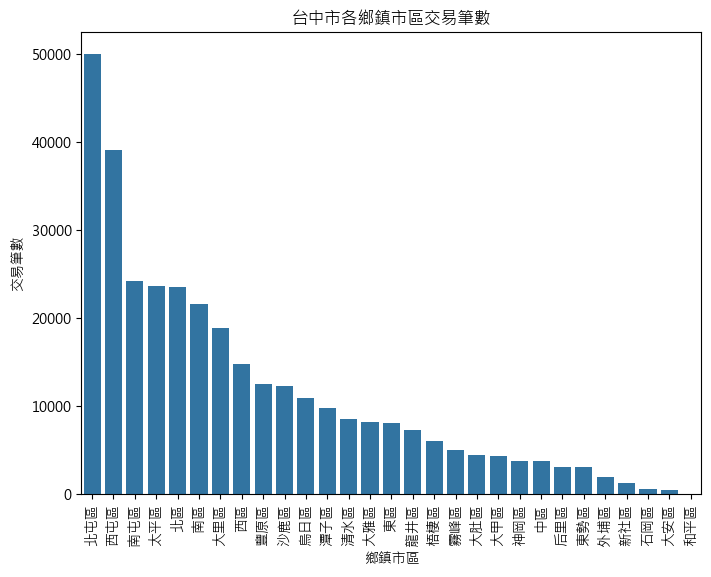

In [127]:
data = pd.DataFrame(df_taichung['鄉鎮市區'].value_counts()).reset_index()
data.columns = ['鄉鎮市區', '交易筆數']

plt.figure(figsize=(8,6))
sns.barplot(x ='鄉鎮市區',y = '交易筆數', data = data)
plt.xticks(rotation = 90)
plt.title('台中市各鄉鎮市區交易筆數')
plt.show()

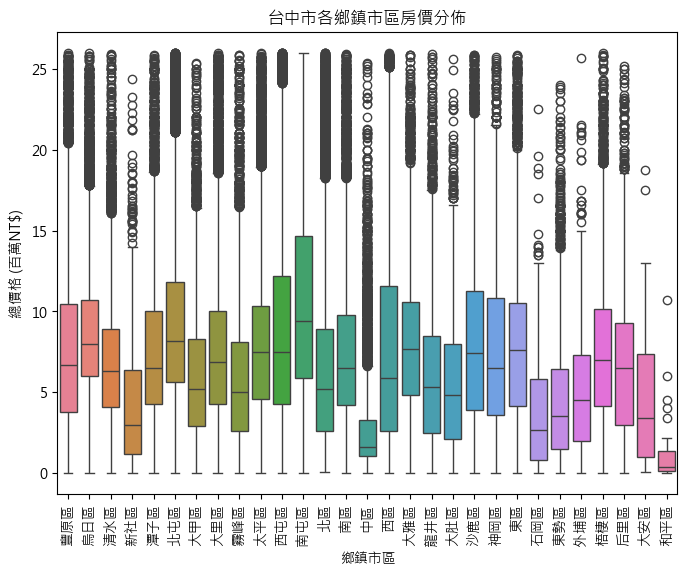

In [128]:
data = df_taichung
data['總價元'] = data['總價元']/1000000

plt.figure(figsize=(8, 6))
sns.boxplot(x='鄉鎮市區', y='總價元', data=df_taichung, hue = '鄉鎮市區')
plt.xticks(rotation=90) 
plt.title('台中市各鄉鎮市區房價分佈')
plt.ylabel('總價格 (百萬NT$)')
plt.xlabel('鄉鎮市區')
plt.show()

C:\Users\erjac\AppData\Local\Temp\ipykernel_29196\1097429990.py:22: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
c:\Users\erjac\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


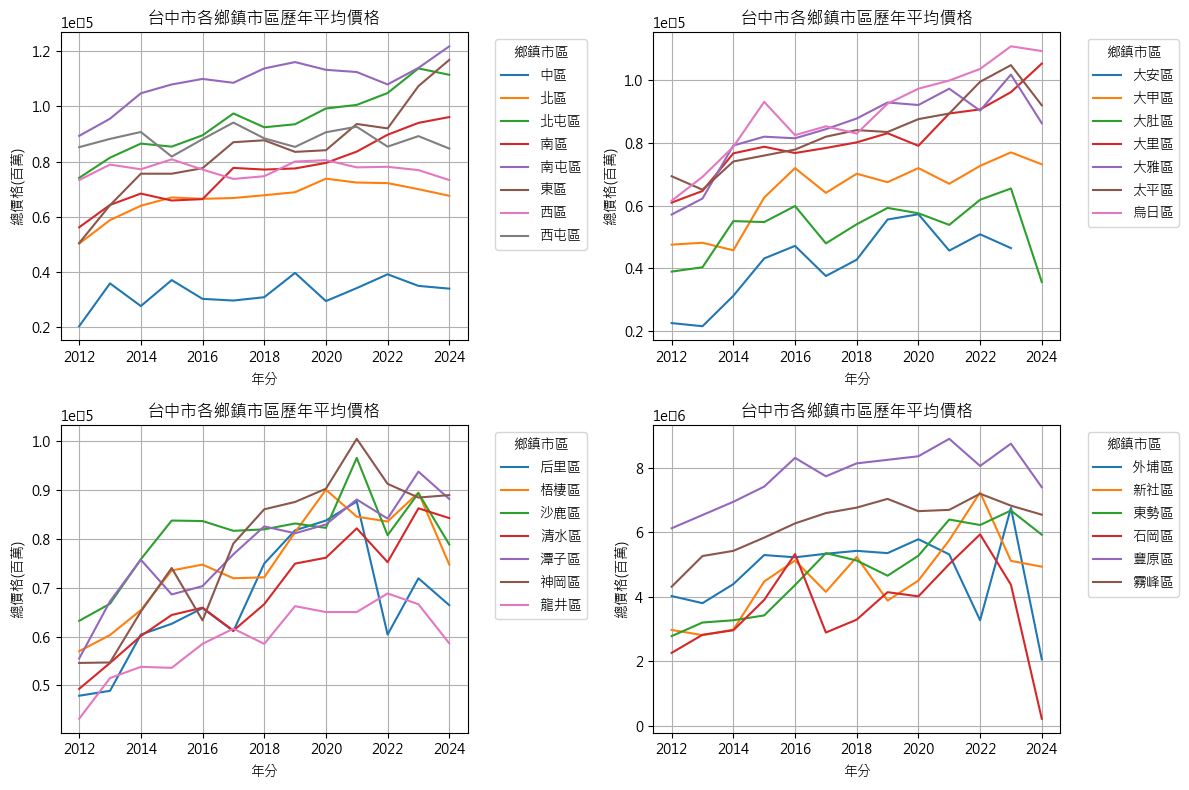

In [129]:
data = df_taichung[['鄉鎮市區','年份','總價元','單價元坪數']].groupby(['鄉鎮市區','年份'],as_index=False).agg(np.mean)
data[['總價元','單價元坪數']] = round(data[['總價元','單價元坪數']],2)
data['總價元(百萬)'] = data['總價元']/1000000

group_1 = ['中區','北區','西區','南區','東區','南屯區','北屯區','西屯區']
group_2 = ['大安區','大肚區','大里區','大雅區','太平區','烏日區','大甲區']
group_3 = ['梧棲區','沙鹿區','后里區','清水區','潭子區','神岡區','龍井區']
group_4 = ['新社區','東勢區','石岡區','豐原區','外埔區','霧峰區']
group_list = [group_1,group_2,group_3,group_4]

fig, axes = plt.subplots(2, 2, figsize=(12, 8)) 

for i, ax in enumerate(axes.flat):
    group_data = data[data['鄉鎮市區'].isin(group_list[i])]
    sns.lineplot(data=group_data, x='年份', y='總價元(百萬)', hue='鄉鎮市區', ax=ax)
    ax.set_title(f'台中市各鄉鎮市區歷年平均價格')
    ax.set_ylabel('總價格(百萬)')
    ax.set_xlabel('年分')
    ax.legend(title='鄉鎮市區', bbox_to_anchor=(1.05, 1), loc=2)
    ax.grid(True)

plt.tight_layout()
plt.show()

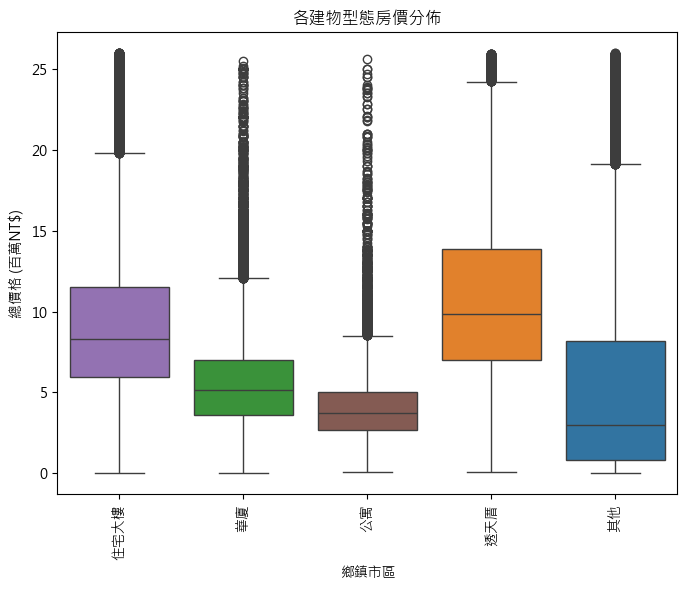

In [130]:
category_order = ['住宅大樓', '華廈', '公寓', '透天厝', '其他']

plt.figure(figsize=(8, 6))
sns.boxplot(x='建物型態', y='總價元', data=df_taichung, hue = '建物型態', order = category_order)
plt.xticks(rotation=90) 
plt.title('各建物型態房價分佈')
plt.ylabel('總價格 (百萬NT$)')
plt.xlabel('鄉鎮市區')
plt.show()

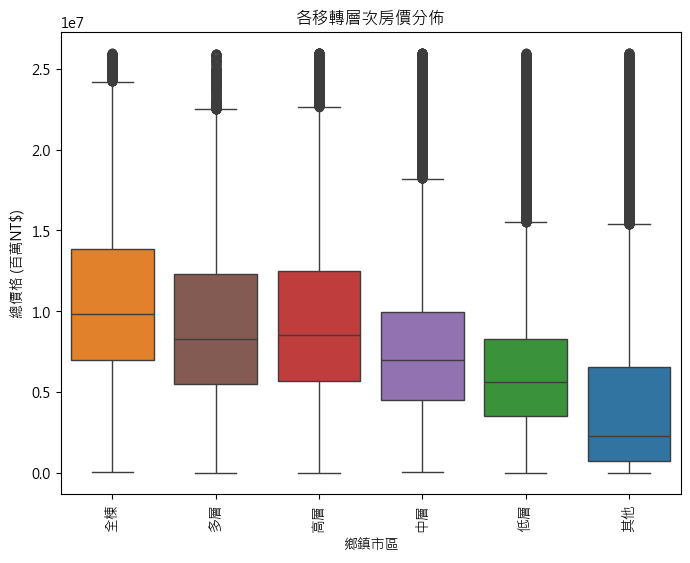

In [92]:
category_order = ['全棟','多層','高層','中層','低層','其他']

plt.figure(figsize=(8, 6))
sns.boxplot(x='移轉層次分類', y='總價元', data=df_taichung, hue = '移轉層次分類', order = category_order)
plt.xticks(rotation=90) 
plt.title('各移轉層次房價分佈')
plt.ylabel('總價格 (百萬NT$)')
plt.xlabel('鄉鎮市區')
plt.show()

---
### 特徵選擇

##### 移除不必要欄位

In [131]:
df_model = df_taichung
df_model.columns

Index(['鄉鎮市區', '交易標的', '土地位置建物門牌', '土地移轉總坪數', '都市土地使用分區', '非都市土地使用分區',
       '非都市土地使用編定', '交易年月日', '交易筆棟數', '移轉層次', '總樓層數', '建物型態', '主要用途', '主要建材',
       '建築完成年月', '建物移轉總坪數', '建物現況格局-房', '建物現況格局-廳', '建物現況格局-衛', '建物現況格局-隔間',
       '有無管理組織', '總價元', '單價元坪數', '車位類別', '車位移轉總坪數', '車位總價元', '編號', '主建物坪數',
       '附屬建物坪數', '陽台坪數', '電梯', '移轉編號', '年份', '總坪數', '屋齡', '預售屋', '移轉層次分類'],
      dtype='object')

In [132]:
df_model = df_model.drop(['交易標的','土地位置建物門牌','交易年月日','建築完成年月','都市土地使用分區', '非都市土地使用分區','非都市土地使用編定','單價元坪數',\
                    '交易筆棟數','移轉層次','編號','主要建材','建物現況格局-隔間','車位類別','主建物坪數','附屬建物坪數','移轉編號', '年份', '總坪數','預售屋','車位總價元'],axis = 1)

In [133]:
df_model.columns

Index(['鄉鎮市區', '土地移轉總坪數', '總樓層數', '建物型態', '主要用途', '建物移轉總坪數', '建物現況格局-房',
       '建物現況格局-廳', '建物現況格局-衛', '有無管理組織', '總價元', '車位移轉總坪數', '陽台坪數', '電梯', '屋齡',
       '移轉層次分類'],
      dtype='object')

##### **One-Hot Encoding 與 Label Encoding**
One-Hot：鄉鎮市區、交易標的、建物型態、主要用途、移轉層次分類

Label：有無管理組織、電梯、預售屋

In [134]:
df_model.select_dtypes(include='object').head()

,鄉鎮市區,建物型態,主要用途,有無管理組織,電梯,移轉層次分類
0,豐原區,其他,其他,無,無,其他
1,烏日區,其他,其他,無,無,其他
3,清水區,透天厝,住家用,無,缺失,全棟
4,新社區,其他,其他,無,無,低層
5,潭子區,其他,其他,無,無,其他


In [135]:
#One Hot Encoding
dummy_list = ['鄉鎮市區','建物型態', '主要用途']
df_model = pd.get_dummies(df_model, columns=dummy_list)

#Laqbel Encoding
management_encoding = {'有':1, '無':0}
evelator_encoding = {'有':1, '無':0, '缺失':-1}
transfer_encoding = {'其他':0, '低層':1, '高層':3, '中層':2, '多層':4,'全棟':5}

df_model['電梯'] = df_model['電梯'].map(evelator_encoding)
df_model['有無管理組織'] = df_model['有無管理組織'].map(management_encoding)
df_model['移轉層次分類'] = df_model['移轉層次分類'].map(transfer_encoding)

In [136]:
df_model.drop(['鄉鎮市區_和平區','建物型態_其他','主要用途_其他'], axis = 1, inplace = True)

---
### 模型預測
在預測房價前，先透過Random Forest來預估屋齡的缺失值

##### 預測屋齡缺失值

In [141]:
age_na = df_model[df_model['屋齡'].isna()]
age_not_na = df_model[df_model['屋齡'].notna()]

y = age_not_na['屋齡']
X = age_not_na.drop('屋齡', axis = 1)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_age = RandomForestRegressor(n_estimators=10,random_state=42, n_jobs = -1)

model_age.fit(X_train,y_train)

y_pred = model_age.predict(X_test)

score_r2 = r2_score(y_test, y_pred)

print('R²:',score_r2)

R²: 0.8836126964924654


In [144]:
age_score_rf = cross_val_score(model_age, X, y, cv=kf, scoring='r2')
print("R²: %0.2f (+/- %0.3f)" % (age_score_rf.mean(), age_score_rf.std()))

R²: 0.88 (+/- 0.002)


In [145]:
age_na_pred = model_age.predict(age_na.drop('屋齡', axis=1))
df_model.loc[df_model['屋齡'].isna(), '屋齡'] = age_na_pred

### 房價預測模型選擇
- LinearRegression

- Random Forest

- Decision Tree

- XGboost

In [146]:
y = df_model['總價元']
X = df_model.drop('總價元',axis = 1)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [147]:
# Linear Regression
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

score_lr = cross_val_score(model_lr,X,y, cv=kf, scoring='r2')
print("R²: %0.2f (+/- %0.3f)" % (score_lr.mean(), score_lr.std()))

R²: 0.72 (+/- 0.003)


In [152]:
# Random Forest
model_rf = RandomForestRegressor(n_estimators=10, random_state=42, n_jobs=-1)
model_rf.fit(X_train,y_train)
y_pred_rf = model_rf.predict(X_test)

score_rf = cross_val_score(model_rf,X,y, cv=kf, scoring='r2')

print("R²: %0.2f (+/- %0.3f)" % (score_rf.mean(), score_rf.std()))

R²: 0.89 (+/- 0.001)


In [149]:
# Decision Tree
model_dt = DecisionTreeRegressor(random_state=42)
model_dt.fit(X_train, y_train)
y_pred_dt = model_dt.predict(X_test)

score_dt = cross_val_score(model_dt, X, y, cv=kf, scoring='r2')
print("R²: %0.2f (+/- %0.3f)" % (score_dt.mean(), score_dt.std()))

R²: 0.82 (+/- 0.002)


In [150]:
# XGboost
model_xgb = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)

score_xgb = cross_val_score(model_xgb,X,y, cv=kf, scoring='r2')
print("R²: %0.2f (+/- %0.3f)" % (score_xgb.mean(), score_xgb.std()))

R²: 0.87 (+/- 0.001)


In [153]:
model_score_list = {'Linear Regression':score_lr.mean(),
                    'Random Forest':score_rf.mean(),
                    'Decision Tree':score_dt.mean(),
                    'XGboost':score_xgb.mean()}

df = pd.DataFrame.from_dict(model_score_list, orient='index', columns=['Score'])
df.reset_index(inplace=True)
df.rename(columns={'index': 'Model'}, inplace=True)
df.sort_values('Score',ascending=False)

,Model,Score
1,Random Forest,0.892613
3,XGboost,0.867308
2,Decision Tree,0.817167
0,Linear Regression,0.715649
